# Spark Machine Learning Tutorial

In order to get started with Spark and MLLib using iPython notebooks, it's necessary to use either the Databricks Spark MOOC Vagrant build or to install iPython Notebook at directed at the Hortonworks site.



### ** Part 1: Building an RDD and Running Statistics **

#### 1(a) Load the data and parse it

In [1]:
# Load Hubway bicycle ride sharing data
import numpy as np
np.set_printoptions(suppress=True)

import pyspark_csv as pycsv
sc.addPyFile('pyspark_csv.py')

def parseLine(x):
    return [int(y) for y in x.split(',')]

import os.path
baseDir = os.path.join('data')
fileName = os.path.join(baseDir, 'HubwayTrips.csv')

rawData = sc.textFile(fileName)

#Drop header row
#Duration,Morning,Afternoon,Evening,Weekday,Male,Age

header = sc.parallelize(rawData.take(1))
rawDataNoHeaders = rawData.subtract(header)

#Parse the lines
rideRDD = rawDataNoHeaders.map(parseLine).cache()
numRecords = rideRDD.count()
minDuration = rideRDD.map(lambda x : x[0]).min()
maxDuration = rideRDD.map(lambda x : x[0]).max()

print "Number of records : %d " % numRecords
print "Minimum duration : %d " % minDuration
print "Maximum duration : %d " % maxDuration



Number of records : 185190 
Minimum duration : 180 
Maximum duration : 85040 


#### 1(b) Use MLLib Statistics 

In [132]:
from pyspark.mllib.stat import Statistics
summary = Statistics.colStats(rideRDD)
print "Duration\tMorning\tAfternoon\tEvening\tWeekday\tMale\tAge\n"
print("%8.2f\t%8.2f\t%8.2f\t%8.2f\t%8.2f\t%8.2f\t%8.2f\n") % tuple(summary.mean())
print("%8.2f\t%8.2f\t%8.2f\t%8.2f\t%8.2f\t%8.2f\t%8.2f\n") % tuple(summary.variance())
print("%8.2f\t%8.2f\t%8.2f\t%8.2f\t%8.2f\t%8.2f\t%8.2f\n") % tuple(summary.numNonzeros())

Duration	Morning	Afternoon	Evening	Weekday	Male	Age

  721.55	    0.33	    0.40	    0.25	    0.83	    0.74	   35.37

1562023.65	    0.22	    0.24	    0.19	    0.14	    0.19	  120.89

185190.00	60399.00	74021.00	46264.00	153689.00	136505.00	185190.00



#### 1(c) Determine correlation of Age with Duration

In [3]:
durationRDD = rideRDD.map(lambda x : x[0]) # Extract duration from the RDD
ageRDD = rideRDD.map(lambda x : x[6]) # Extract Age from the RDD
print(Statistics.corr(durationRDD, ageRDD, method="pearson")) # Print the Pearson correlation of Age vs. Duration

0.0109175889218


### ** Part 2: Linear Regression **

#### ** (2a) Plotting **



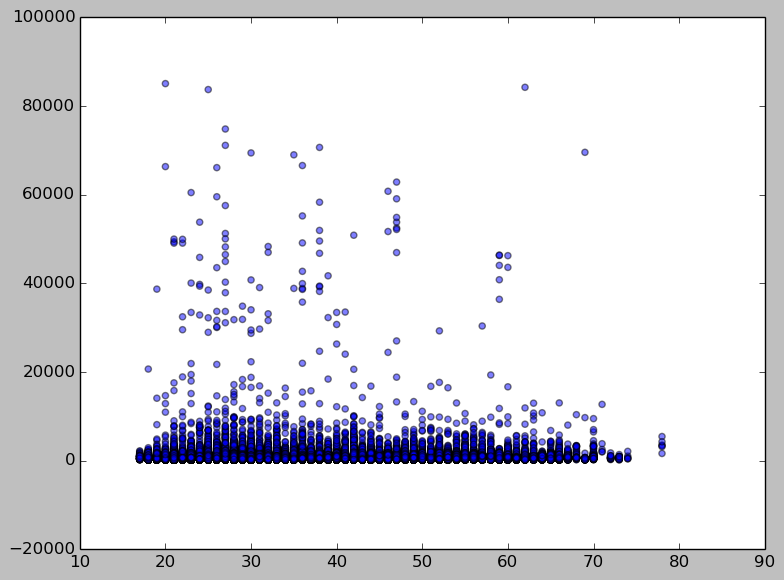

In [4]:
# Plot Age Vs. Duration
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(ageRDD.collect(), durationRDD.collect(),alpha=0.5)
plt.xlabel="Age"
plt.ylabel="Duration"
plt.tight_layout()
plt.show()

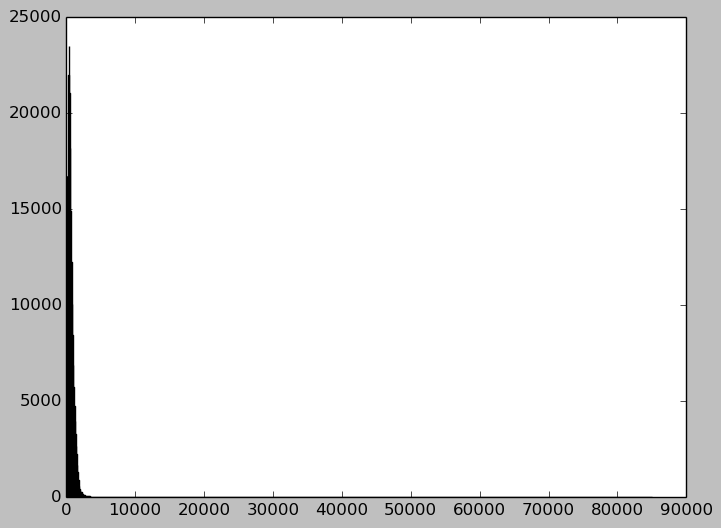

In [5]:
# Plot Duration Histogram

plt.hist(durationRDD.collect(),bins=1000)
plt.xlabel="Duration"
plt.ylabel="Count"
plt.show()

#### ** (2b) LabeledPoints **

Spark uses LabeledPoints for most of its machine learning methods.  It simply consists of an RDD of two-element vectors : the first is the label, the second is an array of features for that point. So, first we have to take our data and convert it to an RDD of LabeledPoints. Since we're predicting Duration, that will be our label.

A simple ParsePoint function that can be mapped over the rawDataRDD will suffice.

In [6]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel

def parsePoint(x):
    return LabeledPoint(x[0],x[1:]) #first field is label, all others are features

labeledRDD = rideRDD.map(parsePoint).cache() #use the parsepoint function to convert the RDD
print labeledRDD.take(5)

[LabeledPoint(415.0, [0.0,1.0,0.0,1.0,1.0,30.0]), LabeledPoint(415.0, [0.0,1.0,0.0,1.0,1.0,30.0]), LabeledPoint(571.0, [1.0,0.0,0.0,0.0,1.0,21.0]), LabeledPoint(772.0, [1.0,0.0,0.0,1.0,0.0,28.0]), LabeledPoint(484.0, [0.0,1.0,0.0,1.0,1.0,32.0])]


#### ** (3b) Linear Regression**

In [7]:

# Build the model
model = LinearRegressionWithSGD.train(labeledRDD)
print model
# Evaluate the model on training data
valuesAndPreds = labeledRDD.map(lambda p: (p.label, model.predict(p.features)))
MSE = valuesAndPreds.map(lambda (v, p): (v - p)**2).reduce(lambda x, y: x + y) / valuesAndPreds.count()
print("Mean Squared Error = " + str(MSE))


(weights=[-6.32866322061e+233,-7.68045135233e+233,-4.28301224765e+233,-1.57278798171e+234,-1.39439410975e+234,-7.24240810206e+235], intercept=0.0)
Mean Squared Error = inf


### ** Part 3: Clustering **

#### Run the Hubway data through a k-means clustering algorithm to look for patterns

In [8]:
from pyspark.mllib.clustering import KMeans, KMeansModel

# Build the model (cluster the data)
clusters = KMeans.train(rideRDD, 5, maxIterations=10,
        runs=10, initializationMode="random")

print "Duration\tMorning\tAfternoon\tEvening\tWeekday\tMale\tAge\n"
for center in clusters.clusterCenters:
    print ("%d8\t%8.2f\t%8.2f\t%8.2f\t%8.2f\t%8.2f\t%8d\n") % tuple(center)
#print clusters.clusterCenters


Duration	Morning	Afternoon	Evening	Weekday	Male	Age

6778	    0.33	    0.39	    0.25	    0.84	    0.72	      35

451038	    0.20	    0.12	    0.56	    0.84	    0.74	      34

3458	    0.35	    0.39	    0.23	    0.85	    0.79	      35

43948	    0.23	    0.49	    0.26	    0.62	    0.62	      37

12828	    0.27	    0.43	    0.28	    0.78	    0.67	      35



### ** Part 4: Regression Tree **
Build a regression tree with the Hubway data to predict duration based on time of day, weekday, gender, and age.

In [9]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = labeledRDD.randomSplit([0.7, 0.3])

# Train a DecisionTree model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
#  Categorical features have already been converted in this data set
model = DecisionTree.trainRegressor(trainingData, categoricalFeaturesInfo={},
                                    impurity='variance', maxDepth=5, maxBins=32)

# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testMSE = labelsAndPredictions.map(lambda (v, p): (v - p) * (v - p)).sum() / float(testData.count())
print('Test Mean Squared Error = ' + str(testMSE))
print ('0:Morning,1:Afternoon,2:Evening,3:Weekday,4:Male,5:Age')
print('Learned regression tree model:')
print(model.toDebugString())

Test Mean Squared Error = 1677704.3489
0:Morning,1:Afternoon,2:Evening,3:Weekday,4:Male,5:Age
Learned regression tree model:
DecisionTreeModel regressor of depth 5 with 63 nodes
  If (feature 4 <= 0.0)
   If (feature 3 <= 0.0)
    If (feature 5 <= 41.0)
     If (feature 5 <= 24.0)
      If (feature 1 <= 0.0)
       Predict: 709.2555720653789
      Else (feature 1 > 0.0)
       Predict: 795.6678899082568
     Else (feature 5 > 24.0)
      If (feature 1 <= 0.0)
       Predict: 847.3722037125178
      Else (feature 1 > 0.0)
       Predict: 929.4401490451793
    Else (feature 5 > 41.0)
     If (feature 5 <= 46.0)
      If (feature 5 <= 45.0)
       Predict: 1157.5087209302326
      Else (feature 5 > 45.0)
       Predict: 2474.6111111111113
     Else (feature 5 > 46.0)
      If (feature 5 <= 48.0)
       Predict: 742.468253968254
      Else (feature 5 > 48.0)
       Predict: 1064.6958224543082
   Else (feature 3 > 0.0)
    If (feature 2 <= 0.0)
     If (feature 5 <= 41.0)
      If (feature 

### ** Part 5: Classification  **
Using PySpark_CSV, read in Titanic data and build classification models for it.

#### (5a) Logistic Regression

In [67]:
from pyspark.sql import SQLContext, Row
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.classification import LogisticRegressionWithSGD


    
sqlCtx = SQLContext(sc)
fileName = os.path.join(baseDir, 'titanic3.csv')
plaintext_rdd = sc.textFile(fileName)
titanicRawRDD = pycsv.csvToDataFrame(sqlCtx, plaintext_rdd).rdd

#remove blank rows
titanicRDD = titanicRawRDD.filter(lambda r : (r[2] != None) )

#pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest

def parseRow(r):
    pclass = r[0]
    sex = 0 if r[3] == 'female' else 1
    age = r[4] if r[4] != None else -1 #flag invalid ages for filtering
    sibsp = r[5]
    parch = r[6]
    fare = r[8] if r[8] != None else -1 #flag missing fares for filtering
    try:
        lp =LabeledPoint(r[1], [pclass,sex,age,sibsp,parch,fare])
    except ValueError:
        lp = None
    return lp
    
#for row in titanicRDD.collect():
#     print row,parseRow(row),isnan(parseRow(row).features[2])
parsedTitanicRDD = titanicRDD.map(parseRow).filter(lambda lp : (lp.features[2] != -1) and (lp.features[5] != -1))
#print parsedTitanicRDD.collect()

pclasses = parsedTitanicRDD.map(lambda lp : lp.features[0]).distinct().collect()
sexes = parsedTitanicRDD.map(lambda lp : lp.features[1]).distinct().collect()
print pclasses
print sexes 

(trainingData, testData) = parsedTitanicRDD.randomSplit([0.7, 0.3])


# Train model
model = LogisticRegressionWithSGD.train(trainingData)

# evaluate the model on test data
results = testData.map(lambda p: (p.label, model.predict(p.features)))

# calculate the error
err = results.filter(lambda (v, p): v != p).count() / float(testData.count())

# Print results
print("Model Error = " + str(err))

[1.0, 2.0, 3.0]
[0.0, 1.0]
Model Error = 0.434504792332


#### ** (5b) Classification Tree **

In [69]:
# Train a DecisionTree model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
#  Categorical features have already been converted in this data set
#print trainingData.collect()
#print testData.collect()
model = DecisionTree.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={0:len(pclasses)+1,1:len(sexes)},
                                    impurity='gini', maxDepth=5, maxBins=32, minInfoGain=0.001)

# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testMSE = labelsAndPredictions.map(lambda (v, p): (v - p) * (v - p)).sum() / float(testData.count())
print('Test Mean Squared Error = ' + str(testMSE))
print('Learned classification tree model:')
print ('Class:Sex:Age:SibSp:ParCh:Fare')
print(model.toDebugString())

Test Mean Squared Error = 0.191693290735
Learned classification tree model:
Class:Sex:Age:SibSp:ParCh:Age
DecisionTreeModel classifier of depth 5 with 51 nodes
  If (feature 1 in {1.0})
   If (feature 2 <= 8.0)
    If (feature 3 <= 2.0)
     If (feature 5 <= 15.85)
      If (feature 5 <= 12.875)
       Predict: 1.0
      Else (feature 5 > 12.875)
       Predict: 0.0
     Else (feature 5 > 15.85)
      Predict: 1.0
    Else (feature 3 > 2.0)
     If (feature 4 <= 1.0)
      Predict: 0.0
     Else (feature 4 > 1.0)
      If (feature 2 <= 2.0)
       Predict: 0.0
      Else (feature 2 > 2.0)
       Predict: 0.0
   Else (feature 2 > 8.0)
    If (feature 0 in {1.0})
     If (feature 2 <= 60.0)
      If (feature 2 <= 14.0)
       Predict: 1.0
      Else (feature 2 > 14.0)
       Predict: 0.0
     Else (feature 2 > 60.0)
      Predict: 0.0
    Else (feature 0 not in {1.0})
     If (feature 2 <= 32.5)
      If (feature 2 <= 31.0)
       Predict: 0.0
      Else (feature 2 > 31.0)
       Predict

### ** Part 6: Recommenders  **
Load the MovieLens data (1m records) and build a recommender with it.

Ratings format : UserID::MovieID::Rating::Timestamp


Movies format : MovieID::Title::Genres


#### **(6a) Loading Data**

In [113]:
def parseRatings(row):
    (userID,MovieID,Rating,Timestamp) = row.split("::")
    return (int(userID),int(MovieID),float(Rating))

def parseMovies(row):
    (MovieID,Title,Genres) = row.split("::")
    return (int(MovieID),Title,Genres)

ratingsRDD = sc.textFile( os.path.join(baseDir, 'ratings.dat')).map(parseRatings).cache()
print ratingsRDD.take(3)
moviesRDD = sc.textFile( os.path.join(baseDir, 'movies.dat')).map(parseMovies).cache()
print moviesRDD.take(3)
#moviesRDD = parseMovieFile('movies.dat').cache()

[(1, 1193, 5.0), (1, 661, 3.0), (1, 914, 3.0)]
[(1, u'Toy Story (1995)', u"Animation|Children's|Comedy"), (2, u'Jumanji (1995)', u"Adventure|Children's|Fantasy"), (3, u'Grumpier Old Men (1995)', u'Comedy|Romance')]


#### ** (6b) Summary statistics and a more complex example **

In [101]:
# Some summary stats on the movie data
numUsersRating = ratingsRDD.map(lambda r : r[0]).distinct().count()
numMoviesRated = ratingsRDD.map(lambda r : r[1]).distinct().count()
totalRatings = ratingsRDD.count()
distinctRatings = ratingsRDD.map(lambda r : r[2]).distinct().collect()
print "Total ratings %d, Total users %d, Total movies %d" % (totalRatings, numUsersRating, numMoviesRated)
print "Distinct Ratings : %s" % distinctRatings
mostRatedMovies = (ratingsRDD
                   .map(lambda r : (r[1],1))
                   .reduceByKey(lambda a,b : a+b)
                   .join(moviesRDD.map(lambda r : (r[0],r[1])))
                   .map(lambda (id,(numRatings, movieTitle)) : (id,movieTitle,numRatings))
                   .takeOrdered(25,key=lambda x : -x[2])                 
                  )
print mostRatedMovies

Total ratings 1000209, Total users 6040, Total movies 3706
Distinct Ratings : [1.0, 2.0, 3.0, 4.0, 5.0]
[(2858, u'American Beauty (1999)', 3428), (260, u'Star Wars: Episode IV - A New Hope (1977)', 2991), (1196, u'Star Wars: Episode V - The Empire Strikes Back (1980)', 2990), (1210, u'Star Wars: Episode VI - Return of the Jedi (1983)', 2883), (480, u'Jurassic Park (1993)', 2672), (2028, u'Saving Private Ryan (1998)', 2653), (589, u'Terminator 2: Judgment Day (1991)', 2649), (2571, u'Matrix, The (1999)', 2590), (1270, u'Back to the Future (1985)', 2583), (593, u'Silence of the Lambs, The (1991)', 2578), (1580, u'Men in Black (1997)', 2538), (1198, u'Raiders of the Lost Ark (1981)', 2514), (608, u'Fargo (1996)', 2513), (2762, u'Sixth Sense, The (1999)', 2459), (110, u'Braveheart (1995)', 2443), (2396, u'Shakespeare in Love (1998)', 2369), (1197, u'Princess Bride, The (1987)', 2318), (527, u"Schindler's List (1993)", 2304), (1617, u'L.A. Confidential (1997)', 2288), (1265, u'Groundhog Day

#### ** (6c) Build the Recommender **

In [126]:
import itertools
import math
from pyspark.mllib.recommendation import ALS

sc.setCheckpointDir('checkpoint/')
ALS.checkpointInterval = 2

#Create training and test sets (could also create a validation set if required)
(trainingData, testData) = ratingsRDD.randomSplit([0.7, 0.3])

model = ALS.train(trainingData, 8, 5, 0.1)
test_for_predict_RDD = testData.map(lambda x: (x[0], x[1]))
predictions = model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = testData.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())

print 'For testing data the RMSE is %s' % (error)
print rates_and_preds.take(10)

For testing data the RMSE is 0.896336806338
[((1861, 3911), (3.0, 3.3456925527076757)), ((5283, 2081), (3.0, 3.415509846366383)), ((1150, 322), (5.0, 2.4951223727567147)), ((3378, 2124), (4.0, 3.2772129053995087)), ((1051, 593), (5.0, 4.076649866427813)), ((77, 2723), (1.0, 3.0302801910753807)), ((696, 1196), (4.0, 4.048061945614126)), ((3200, 1208), (5.0, 4.067235318955074)), ((4604, 1610), (2.0, 3.11472507852392)), ((874, 2366), (3.0, 3.704751356330039))]


#### ** (6d) Add personalized data **

In [131]:
#Rate some movies to get personalized recommendations

myRatingsRDD = sc.parallelize ([
        [0,2858,3.0],
        [0,260,5.0],
        [0,1196,4.0],
        [0,480,4.0],
        [0,589,5.0],
        [0,1270,5.0],
        [0,1198,5.0],
        [0,1097,4.0],
        [0,858,2.0]
    ])

#Retrain the model with my preferences
#Exclude movies I've rated from the prediction set

newTrainingData = ratingsRDD.union(myRatingsRDD)
model = ALS.train(newTrainingData, 8, 5, 0.1)

#Generate (0,movieid) pairs for movies I haven't rated -- candidates for scoring
moviesIRated = myRatingsRDD.map(lambda row : row[1]).distinct().collect()
myUnratedMoviesRDD = (moviesRDD.filter(lambda x: x[0] not in moviesIRated).map(lambda x: (0, x[0])))

predictions = model.predictAll(myUnratedMoviesRDD).collect()
recommendations = sorted(predictions, key=lambda x: x[2], reverse=True)[:20]

movies = moviesRDD.collect() #bring locally to print
print "Movies recommended for you:"
for i in xrange(len(recommendations)):
    print ("%2d: %s" % (i + 1, movies[recommendations[i][1]])).encode('ascii', 'ignore')

Movies recommended for you:
 1: (3451, u"Guess Who's Coming to Dinner (1967)", u'Comedy|Drama')
 2: (2631, u'Frogs for Snakes (1998)', u'Comedy|Film-Noir|Thriller')
 3: (38, u'It Takes Two (1995)', u'Comedy')
 4: (576, u'Fausto (1993)', u'Comedy')
 5: (2196, u'Knock Off (1998)', u'Action')
 6: (561, u'Killer (Bulletproof Heart) (1994)', u'Thriller')
 7: (1920, u'Small Soldiers (1998)', u"Animation|Children's|Fantasy|War")
 8: (2266, u"Butcher's Wife, The (1991)", u'Comedy|Romance')
 9: (970, u'Beat the Devil (1954)', u'Comedy|Drama')
10: (1804, u'Newton Boys, The (1998)', u'Crime|Drama')
11: (1228, u'Raging Bull (1980)', u'Drama')
12: (1311, u'Santa with Muscles (1996)', u'Comedy')
13: (3672, u'Benji (1974)', u"Adventure|Children's")
14: (1707, u'Home Alone 3 (1997)', u"Children's|Comedy")
15: (2640, u'Superman (1978)', u'Action|Adventure|Sci-Fi')
16: (3383, u'Big Fella (1937)', u'Drama|Musical')
17: (577, u'Andre (1994)', u"Adventure|Children's")
18: (765, u'Jack (1996)', u'Comedy|Dra